# 1. Download, Load and Visualise the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

---

In this notebook, we download images from the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) database into the `FashionMNIST_data/` directory in this notebook. Since this database is widely used for training neural networks, PyTorch has conveniently provided it as a built-in dataset that we can use.

Then, we will load the images into batches with a `DataLoader` and visualise the images.

It might take a minute to download all the data.

### Outline of this notebook
>1. Download Fashion-MNIST data from PyTorch
    - 1.1: `Datasets` class
<br>
<br>
2. Load the data
    - 2.1: Define a transformation
    - 2.2: Construct training, validation and testing datasets
    - 2.3: Load datasets into a `DataLoader`
<br>
<br>
3. Visualise the data
    - 3.1: Description of the data
    - 3.2: Visualise a batch
    - 3.3: Visualise a single image
    - 3.4: _Zoom in_ on a single image
        - 3.4.1: Normalisation
    
---

### 1. Download Fashion-MNIST data from PyTorch

#### 1.1 [`Datasets` class](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

The `torch.utils.data.Dataset` is a Dataset class in `torch` that allows us to:
1. Load batches of image data
2. Define and apply transformations to the data that we load into our neural network


In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets

# Download training and testing dataset from torchvision.datasets
train_set = datasets.FashionMNIST(root = 'FashionMNIST_data', train = True, download = True)
test_set = datasets.FashionMNIST(root = 'FashionMNIST_data', train = False, download = True)

---

### 2. Load the data

####  2.1: Define a transformation

Before downloading the data, we need to define what are the transformations we want to perform on the images before feeding them into our model. We do this using `torchvision.transforms`.

Transformations are essential for three main reasons:
1. Introducing randomness into the dataset with random transformations such as flips, crops and rotations.
    - You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html).
2. Normalising our images.
    - We will elaborate more about normalisation in part 3.4 of this notebook.
3. Turning our images into Tensors for input into our neural network
    - The output of torchvision datasets are `PILImage` images of range [0, 1]. We need to transform them to Tensors that our neural networks can read. 

_(Note that when we are testing, we will want to use images that aren't altered other than normalising. Hence we set two different transformations, one for the training set and one for the testing set)._

In [2]:
from torchvision import transforms

# Define a transform for training set
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, ), (0.5, ))])

# Define a transform for testing set
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, ), (0.5, ))])

#### 2.2: Construct training, validation and testing datasets

Now that we have defined our transformations, we will construct our training, validation and testing dataset.

To construct the training set and testing set, we set `train = True` and `train = False` respectively. As taken from the documentation:
- `train`: If `True`, creates dataset from `training.pt`, otherwise from `test.pt`.

(Note that we have already downloaded the images into the `./FashionMNIST_data/` directory in Step 1)

<img src='.\Complementary_Pictures\1_validation_set.jpeg' width = 60%>

Simple explanation of the three datasets:
- _Training set_: The sample of data used to fit the model
- _Validatin set_: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hypterparameters. This is the set where the model 'occasionally sees' but is never used as part of the learning (i.e. updating of hyperparameters).
- _Test set_: the sample of data used to provide an unbiased evaluation of a model's final fit on the training set.

There is no one rule for the training-validation-test set split. It really depends on the use case and is open to experimentation to find the best fit.

In [3]:
# Constructing training and testing datasets
# We set download=False because the data has already been downloaded
train_set = datasets.FashionMNIST(root='./FashionMNIST_data', train=True, download=False, transform=train_transform)
test_set = datasets.FashionMNIST(root='./FashionMNIST_data', train=False, download=False, transform=test_transform)

# Percentage of training set to use as validation set
validation = 0.2

# Obtain training indices that will be used for the validation set
training_size = len(train_set)
indices = list(range(training_size))
np.random.shuffle(indices) # Randomly shuffles the elements of `indices` in-place
split = int(np.floor(validation * training_size)) # Returns the number of images in the validation set
train_index = indices[:split]
validation_index = indices[split:]

from torch.utils.data.sampler import SubsetRandomSampler

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
validation_sampler = SubsetRandomSampler(validation_index)

#### 2.3: Load datasets into a [`DataLoader`](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

Once we have constructed the datasets, we will use `torch.utils.data.DataLoader`. The `DataLoader` is an iterator that allows us to:
- separate our images into bathes (by defining `batch_size`)
- and also randomly shuffle our data after every training epoch (`shuffle=True`). But in our case, since we used a `sampler` to partition out a validation set from the training set, `shuffle` has to be `False`.

We also specify the labels of clothing items in the list `classes`. The order of this list is important, it follows the order specified in the [Fashion-MNIST documentation](http://github.com/zalandoresearch/fashion-mnist).

In [4]:
# Set our desired batch size
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size = batch_size,
                                           sampler = train_sampler, 
                                           shuffle = False)

validation_loader = torch.utils.data.DataLoader(train_set, 
                                                batch_size = batch_size, 
                                                sampler = validation_sampler, 
                                                shuffle = False)

test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size = batch_size, 
                                          shuffle = True)

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

---
### 3. Visualise the data

We will take a closer look at the training data to gain a better understanding. This also serves to check whether we have downloaded the data properly. 

#### 3.1: Description of the data
The Fashion-MNIST dataset is a collection of 70,000 images split into a training set of 60,000 images and a testing set of 10,000 images. Each `image` has a `label` attached to it.

- `image`: Greyscale image of size 28x28 pixels.


- `label`: The actual clothing item that is shown in the image. There are 10 mutually exclusive classes. This label is the 'correct answer' that we will check our model's classification outputs against.

We first look at the shape of the images and the labels. Here, we are taking only the first batch with `.next()` to check our data. We'll see below that `images` is a tensor with a shape `torch.Size([64, 1, 28, 28])`. So, 64 images per batch, 1 color channel, and each image is 28x28 pixels. Similarly, the `labels` have a shape `torch.Size([64])` because the 64 images in each batch should have 64 labels respectively.

In [5]:
# Calling the first batch from the train_loader DataLoader
data_iter = iter(train_loader)
images, labels = data_iter.next()

print("`images` type:", type(images))
print("`images` shape:", images.shape)
print("`labels` shape:", labels.shape)

`images` type: <class 'torch.Tensor'>
`images` shape: torch.Size([64, 1, 28, 28])
`labels` shape: torch.Size([64])


#### 3.2: Visualise a batch

Let us display the 64 images in the first batch to get a better intuition of how the dataset looks like. Notice how the images are randomly flipped horizontally, just as we intended!

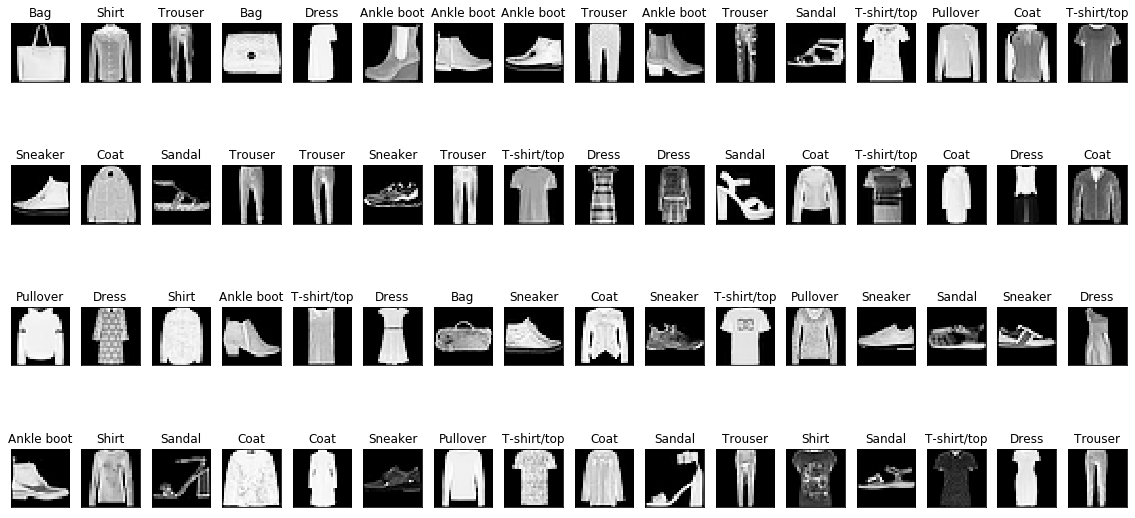

In [6]:
%matplotlib inline

# Convert `images` from torch.Tensor datatype to a
# NumPy multidimensional array
images = images.numpy()

# Iterate and plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))

for i in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    # Squeezes each image into a 2-dim array (28x28 pixels)
    img = np.squeeze(images[i])
    ax.imshow(img, cmap='Greys_r')
    # .item() gets the value contained in a Tensor
    ax.set_title(classes[labels[i].item()])

#### 3.3: Visualise a single image

Looking at the first image of the first batch:

Text(0.5, 1.0, 'Label: Bag')

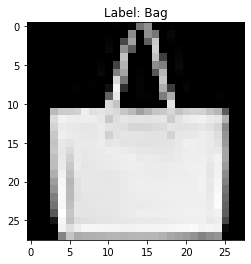

In [7]:
# This is what the first image of the first batch looks like:
plt.imshow(np.squeeze(images[0]), cmap='Greys_r')
plt.title(f"Label: {classes[labels[0].item()]}")

#### 3.4: _Zooming in_ on a single image

To take this a step further, let us view the above image in more detail to understand what we meant by representing pixels of an image as numbers. While our eyes view the image as a picture, our model 'sees' the image as a vector of numbers.

#### 3.4.1: Normalisation

Recall that when we were defining `train_transform` and `test_transform`, we normalised the images by doing `transforms.Normalize((0.5, ), (0.5, )`. Normalisation is one of the three forms of [data preprocessing](http://cs231n.github.io/neural-networks-2/#datapre). Specifically, we can:

1. `img - img.mean()`: This centers the pixel values around 0.
2. `[img - img.mean()] / img.std()`: This centers the pixel values around 0, then divides each pixel value by the standard deviation of the pixel values' distribution. This pixel value will be the number of std that the pixel is away from the mean.
    - Pixel value = -1: Black
    - Pixel value = 0: Grey
    - Pixel value = 1: White

In this case, it is not crucial to normalise the pixel values, since the images are all greyscale and all have a standard scale of [0, 255].  But in a case where our inputs have different features with different scales, normalising and standardising is important in ensuring that all features of the input have the same scale. This ensures that we are not 'overcompensating' a correction of weights in one weight dimension while undercompensating in another during backpropogation.

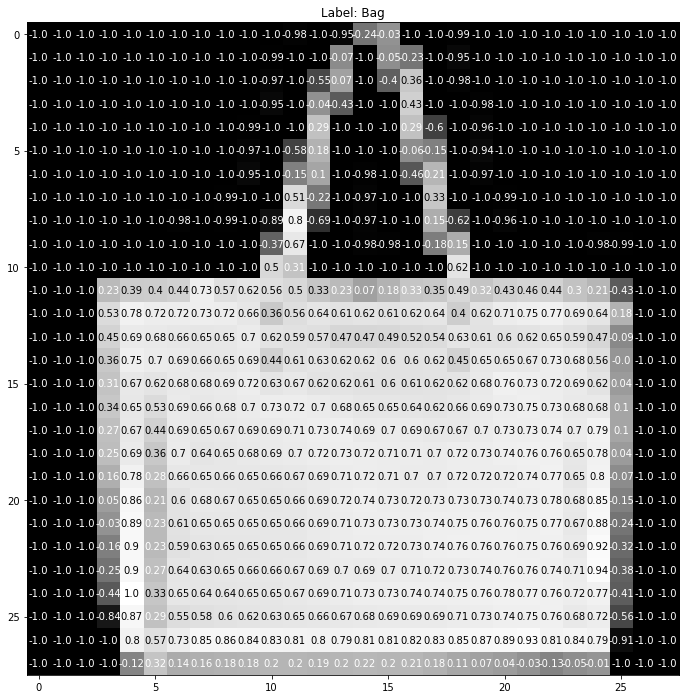

In [8]:
# We select the first image
img = np.squeeze(images[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, cmap='Greys_r')
ax.set_title(f"Label: {classes[labels[0].item()]}")

# Set variables for width and height of img 
width, height = img.shape

# Set a threshold to determine the colour of the annotations in each pixel
thresh = img.max()/3

# Iterate through each pixel from left to right,
for x in range(width):
    # from top to bottom
    for y in range(height):
        # Get value of the pixel
        pixel_val = round(img[x][y],2) if img[x][y] != 0 else 0
        # Annotate pixel_val on the plot using `thresh` to ensure visibility of annotations
        ax.annotate(str(pixel_val),
                    xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')